In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py 
import visualisation as vis
import metric_dreem
import torch
import torch.nn as nn
from torch.optim import Adam
import utils 
import tqdm

In [2]:
data_x_train = h5py.File('../data/X_train.h5')
data_x_test = h5py.File('../data/X_test.h5')
data_x_train['data'].shape, data_x_test['data'].shape
mask_y_train = np.array(pd.read_csv('../data/y_train.csv'))

In [3]:
# create sub-sampled dataset
n_samples = 4400
n_subjects = 22
rate = 100

means_data = utils.subsampling_data(data_x_train,rate)
vars_data = utils.subsampling_data_var(data_x_train, rate)

In [4]:
utils.normalization(means_data)
utils.normalization(vars_data)
means_data.shape, vars_data.shape

((4400, 8, 90), (4400, 8, 90))

In [5]:
features = np.zeros((n_samples*90, 2*8))
for k in range(8):
    features[:,k] = means_data[:,k].reshape(-1) 
    features[:,8+k] = vars_data[:,k].reshape(-1)

In [6]:
targets = mask_y_train[:,1:].reshape(-1,1)
features.shape, targets.shape

((396000, 16), (396000, 1))

In [7]:
positives = []
negatives = []
for k in range(len(targets)):
    if targets[k]:
        positives.append(features[k])
    else:
        negatives.append(features[k])
positives = np.array(positives)
negatives = np.array(negatives)
positives.shape, negatives.shape

((27214, 16), (368786, 16))

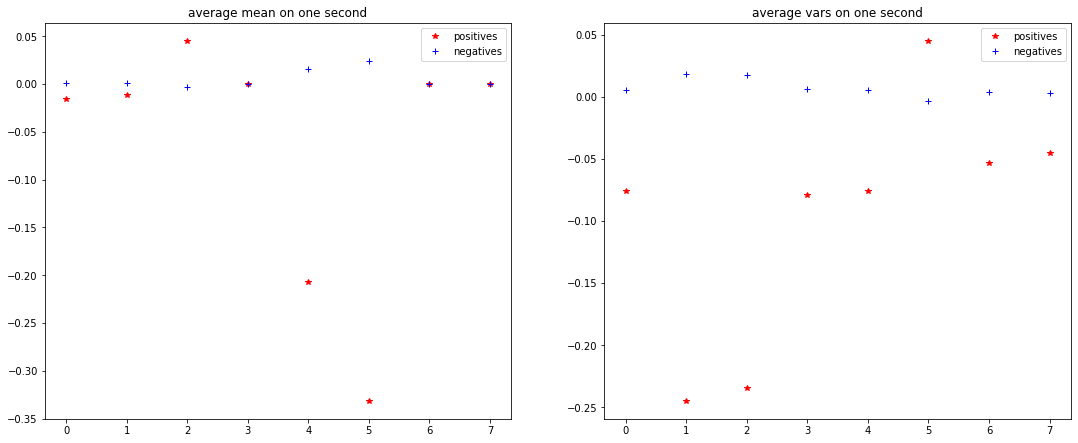

In [8]:
plt.subplot(121)
plt.plot(positives[:,:8].mean(axis=0), '*r', label = 'positives')
plt.plot(negatives[:,:8].mean(axis=0), '+b', label = 'negatives')
plt.legend()
plt.title("average mean on one second")
plt.subplot(122)
plt.plot(positives[:,8:].mean(axis=0), '*r', label = 'positives')
plt.plot(negatives[:,8:].mean(axis=0), '+b', label = 'negatives')
plt.legend()
plt.title("average vars on one second")
plt.subplots_adjust(top=1.5, right=2.5)

In [9]:
training_size = 200*17*90 #(5 subjects are validation)


In [10]:
training_features, training_targets = utils.eliminating_zeros(features[:training_size], targets[:training_size], 0.5)

In [11]:
targets.mean(), training_targets.mean()

(0.06872222222222223, 0.13278724520292276)

In [12]:
#Convert the dataset to a tensor
#Dataloader
batch_size=16
train_loader, valid_loader = utils.dataloader(features[:training_size], targets[:training_size],
        features[training_size:], targets[training_size:], batch_size=batch_size)

The train set contains 306000 samples, in 19125 batches
The validation set contains 90000 samples, in 5625 batches


In [32]:
FNN_shape = [16,48,32,1]

In [33]:
# Model definition 
def linear_tanh(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),
            nn.Tanh()]


def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),
            nn.ReLU()]

def linear_sigm(dim_in, dim_out, drop=0):
    return [nn.Dropout(drop),
            nn.Linear(dim_in, dim_out),
            nn.Sigmoid()]

class FC_Network(torch.nn.Module):
    def __init__(self):
        super(FC_Network, self).__init__()
        
        self.regressor =  nn.Sequential(
            #nn.Dropout(0.2),
            *linear_tanh(FNN_shape[0], FNN_shape[1]),
            nn.Dropout(0), #Generally 0.2 for the input layer and 0.5 for the hidden layer
            *linear_tanh(FNN_shape[1], FNN_shape[2]),
            nn.Dropout(0),
            #nn.Linear(50, output_size)
            *linear_sigm(FNN_shape[2], FNN_shape[3])
        )
        
    def forward(self,x):  
        x = torch.flatten(x, start_dim=1).float()
        y = self.regressor(x).float()
        return y
    
    def transform_targets(self,y): 
        return y.float()
    
    def transform_outputs(self,x): 
        return x.float()
    
    
model = FC_Network()
#model.to(utils.device)

In [34]:
#dummy_input = next(iter(train_loader))[0]
#torch.onnx.export(model, dummy_input, 'FNN.onnx')

In [35]:
#To save the best model over epochs
model_name = "FNN_features"

In [36]:
num_epochs = 10
optimizer = Adam(model.parameters(), lr=0.002)
# f_loss = torch.nn.MSELoss()
f_loss = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) #Adjusting the learning rate

In [37]:
model.__init__

<bound method FC_Network.__init__ of FC_Network(
  (regressor): Sequential(
    (0): Linear(in_features=16, out_features=48, bias=True)
    (1): Tanh()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=48, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0, inplace=False)
    (6): Dropout(p=0, inplace=False)
    (7): Linear(in_features=32, out_features=1, bias=True)
    (8): Sigmoid()
  )
)>

In [38]:
utils.train_model(train_loader, valid_loader, model, 'special', optimizer, scheduler, num_epochs, 80)


  1%|          | 156/19125 [00:00<00:24, 790.13it/s]Epoch 0/9
----------
  1%|          | 158/19125 [00:00<00:23, 792.49it/s]val Loss: 0.0352 Acc: 0.2677

Epoch 1/9
----------
  1%|          | 148/19125 [00:00<00:25, 739.27it/s]val Loss: 0.0330 Acc: 0.3069

Epoch 2/9
----------
  1%|          | 174/19125 [00:00<00:21, 866.35it/s]val Loss: 0.0339 Acc: 0.3040

Epoch 3/9
----------
  1%|          | 189/19125 [00:00<00:20, 946.27it/s]val Loss: 0.0347 Acc: 0.3120

Epoch 4/9
----------
  0%|          | 77/19125 [00:00<00:28, 665.67it/s]val Loss: 0.0325 Acc: 0.2908

Epoch 5/9
----------
  0%|          | 91/19125 [00:00<00:24, 791.83it/s]val Loss: 0.0349 Acc: 0.2983

Epoch 6/9
----------
  0%|          | 81/19125 [00:00<00:23, 798.48it/s]val Loss: 0.0346 Acc: 0.3067

Epoch 7/9
----------
  1%|          | 183/19125 [00:00<00:20, 923.25it/s]val Loss: 0.0351 Acc: 0.3189

Epoch 8/9
----------
  1%|          | 176/19125 [00:00<00:21, 884.13it/s]val Loss: 0.0357 Acc: 0.3110

Epoch 9/9
----------
100

FC_Network(
  (regressor): Sequential(
    (0): Linear(in_features=16, out_features=48, bias=True)
    (1): Tanh()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=48, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0, inplace=False)
    (6): Dropout(p=0, inplace=False)
    (7): Linear(in_features=32, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [39]:
predictions = model.forward(torch.tensor(valid_loader.dataset.inputs)).detach().numpy().reshape(-1,90)
predictions.mean(), valid_loader.dataset.targets.mean()


(0.67907286, 0.060477777777777776)

c:\Users\sacha\Desktop\CentraleSupélec\cours 3a\SD10\DataScience\sleepapnea\Code\metric_dreem.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)


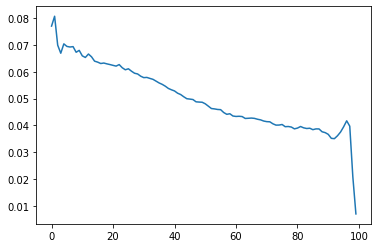

In [40]:
threshold_grid_search = np.zeros(100)
for k in range(100):
    try:
        threshold_grid_search[k] = metric_dreem.dreem_sleep_apnea_custom_metric(predictions>k/100, valid_loader.dataset.targets.reshape(-1,90))
    except:
        threshold_grid_search[k] = -0.1
plt.plot(threshold_grid_search)

In [41]:
results = metric_dreem.dreem_sleep_apnea_custom_metric(utils.low_band_filter(predictions>0.25).reshape(5,-1), 
                                            valid_loader.dataset.targets.reshape(5,-1))
best_results = np.load("best_results.npy")
print('results: {:.4f} , best results: {:.4f}'.format(results, best_results))

results: 0.0588 , best results: 0.4690
c:\Users\sacha\Desktop\CentraleSupélec\cours 3a\SD10\DataScience\sleepapnea\Code\metric_dreem.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)
